In [1]:
# Ensure the module is automatically reloaded when rerunning the import command.
# %load_ext autoreload
# %autoreload 2

import piv_functions as piv

In [2]:
directory = 'PIVimages/shearflow/'
prefix = None
type = 'png'
images = piv.read_image_directory(directory, prefix, type)

wind: (2, 32, 8, 32, 128)
coord: (32, 8, 2)
corr: (32, 8, 63, 255)
disp: (32, 8, 2)


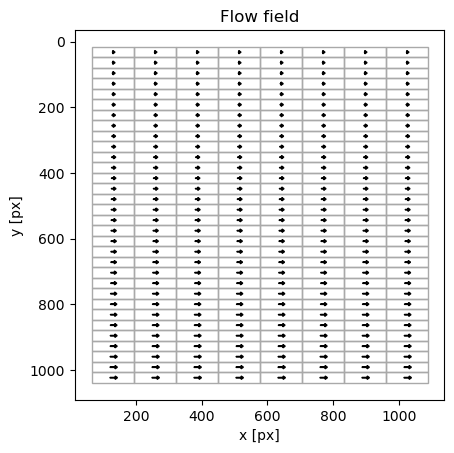

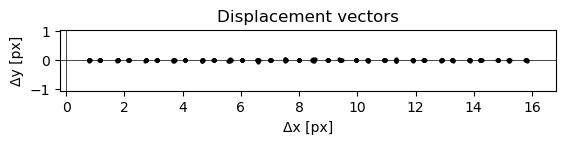

In [5]:
velocities, coordinates = piv.simple_piv(images, (32, 128), plot=True, plot_flow_field_params={'arrow_scale': 1})

In [4]:
windows, coordinates = piv.divide_in_windows(images[0], (128,64))